In [5]:
from geometry import *
import numpy as np
import pypower
import scipy.optimize as opt
import matplotlib.pyplot as plt
%matplotlib inline

def make_power(X,w):
    A = np.array([[ 0, 0, 1],
                  [ 0, 0,-1],
                  [ 0, 1, 0],
                  [ 0,-1, 0],
                  [ 1, 0, 0],
                  [-1, 0, 0]])
    b = np.array([100,0,1,1,1,1])
    return pypower.power_diagram(X,w,A,b)

# X=(x,y,z) is above the graph of (x,y) -> sqrt(|(x,y)-p|^2 + beta**2) + b_i
# <=> z >= sqrt((x-px)^2 + (y-py)^2 + beta**2) + b_i
# <=> (z-b_i)^2 >= (x-px)^2 + (y-py)^2 + beta**2 (AND z>=b_i...)
# <=> <Q(X-R)|(X-R)> - beta**2 >= 0
# with Q = diag(-1,-1,1), R = (px,py,bi)
# <=> <QX|X> + 2<QR|X> + <QR|R> - beta**2 >= 0



def make_hyperboloid(p, b, beta):
    Q = np.diag([-1,-1,1])
    R = np.array([p[0],p[1],b])
    b = 2*Q@R,
    c = np.dot(Q@R,R) - beta**2
    return Quadric(Q,b,c)


def make_laguerre(Y, psi, beta, k=20):
    assert(all(psi > 0))
    N = len(Y)
    X = np.zeros((N,3))
    X[:,0:2] = Y
    X[:,2] = -psi
    #w = 2*(Y[:,0]**2 + Y[:,1]**2)
    w = 2*psi**2
    
    cells = make_power(X,w)
    curves = []
    for i in range(N):
        quad = make_hyperboloid(Y[i], psi[i], beta)
        c = intersect_cell_with_quadric(X,cells[i],quad,k)
        curves.append(c)
    return curves

def plot_laguerre(allcurves):
    areas = []
    for curves in allcurves:
        area = 0
        for j,curvesj in curves.items():
            for crv in curvesj:
                crv = np.array(crv)
                for i in range(crv.shape[0]-1):
                    a = crv[i,0:2]
                    b = crv[i+1,0:2]
                    area += np.linalg.det(np.array([a,b]))/2
                plt.plot(crv[:,0], crv[:,1], '.k')
        areas.append(area)
    return areas

def nabla_y_cost(x,y,beta):
    return (y-x)/ np.sqrt(np.linalg.norm(x-y)**2 + beta**2)

def compute_H_DH_from_laguerre(Y, beta, allcurves):
    areas = []
    N = len(allcurves)
    areas = np.zeros(N)
    DH = np.zeros((N,N))
    for i in range(N):
        curves = allcurves[i]
        for j,curvesj in curves.items():
            for crv in curvesj:
                crv = np.array(crv)
                for k in range(crv.shape[0]-1):
                    a = crv[k,0:2]
                    b = crv[k+1,0:2]
                    areas[i] += np.linalg.det(np.array([a,b]))/2
                    if j<0:
                        continue
                    length  = np.linalg.norm(b-a)
                    x = (a+b)/2
                    hij = length/np.linalg.norm(nabla_y_cost(x,Y[i],beta) - nabla_y_cost(x,Y[j],beta))
                    DH[i,j] += hij
                    DH[i,i] -= hij
    return np.array(areas), DH

[0.5042261367100779, 0.19384753274511193, 0.31326332748060004, 0.3473653493869136, 0.23453969798852725, 0.42877178158697943, 0.37176627343777485, 0.44660282828306963, 0.7111459717997967, 0.44892347879867656]
4.000452378217528
0.00015118889613295898


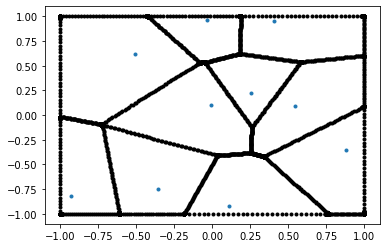

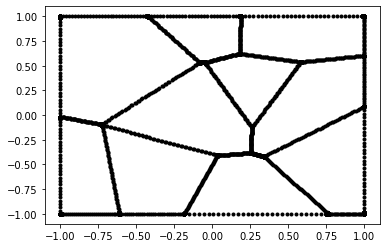

In [2]:
N = 10
Y = 2*(np.random.rand(N,2)-.5)
psi = 0.001*np.random.rand(N)
beta = 1
curves = make_laguerre(Y, psi, beta,k=30)

plt.figure()
areas = plot_laguerre(curves)
plt.plot(Y[:,0],Y[:,1],'.')
print(areas)
print(np.sum(areas))


psi += 0.2
curves = make_laguerre(Y, psi, beta, k=30)
plt.figure()
areas2 = plot_laguerre(curves)
print(np.linalg.norm(np.array(areas)-np.array(areas2))/N)

In [13]:
def check_gradient(f,gradf,x0):
    N = len(x0)
    gg = np.zeros((N,N))
    for i in range(N):
        eps = 1e-2
        e = np.zeros(N)
        e[i] = eps
        gg[i,:] = (f(x0+e) - f(x0-e))/(2*eps)
    print('erreur numérique dans le calcul du gradient: %g (doit être petit)' % np.linalg.norm(gradf(x0)-gg))
    print(gradf(x0))
    print(gg)
    
N = 5
Y = 2*(np.random.rand(N,2)-.5)
beta = 1

H = lambda psi: compute_H_DH_from_laguerre(Y,beta,make_laguerre(Y, psi, beta, k=1000))[0]
DH = lambda psi: compute_H_DH_from_laguerre(Y,beta,make_laguerre(Y, psi, beta, k=1000))[1]

psi = 0.11*np.ones(N)
np.set_printoptions(2)
check_gradient(H,DH,psi)

erreur numérique dans le calcul du gradient: 8.90001 (doit être petit)
[[ -2.11   1.11   0.     0.85   0.15]
 [  1.11  -2.56   0.13   0.     1.32]
 [  0.     0.13  -2.82   0.32   2.37]
 [  0.85   0.     0.32  -7.92   6.75]
 [  0.15   1.32   2.37   6.75 -10.58]]
[[-2.23e+00  7.35e-01 -2.61e-13  1.10e+00  1.33e-01]
 [ 9.06e-01 -2.48e+00  2.50e-01  5.66e-13  1.61e+00]
 [-1.45e-11  2.14e-01 -5.77e+00  6.42e-01  4.30e+00]
 [ 1.17e+00 -2.61e-12  7.12e-01 -1.17e+01  9.75e+00]
 [ 1.56e-01  1.53e+00  4.80e+00  9.90e+00 -1.57e+01]]


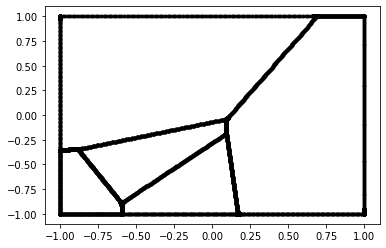

0 -> 
H(psi) =  [1.47 1.63 0.19 0.35 0.36]
psi =  [0.11 0.11 0.11 0.11 0.11]


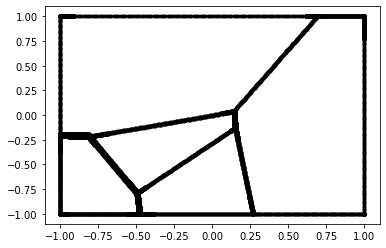

[[ -2.14   1.02   0.     0.93   0.2 ]
 [  1.04  -2.55   0.21   0.     1.31]
 [  0.     0.22  -3.55   0.64   2.69]
 [  0.92   0.     0.61  -8.06   6.53]
 [  0.19   1.31   2.64   6.52 -10.66]]
t=0.1
1 -> 
H(psi) =  [1.39 1.54 0.32 0.4  0.38]
psi =  [0.19 0.19 0.11 0.13 0.13]


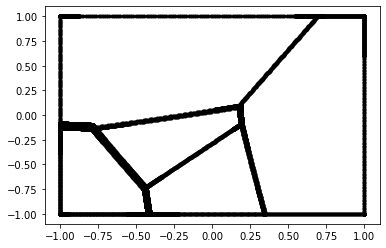

[[ -2.18   0.96   0.     0.99   0.22]
 [  1.    -2.57   0.24   0.     1.33]
 [  0.     0.26  -4.12   0.82   3.04]
 [  0.98   0.     0.77  -8.32   6.57]
 [  0.21   1.35   2.92   6.54 -11.02]]
t=0.1
2 -> 
H(psi) =  [1.33 1.47 0.4  0.44 0.4 ]
psi =  [0.25 0.25 0.11 0.14 0.14]


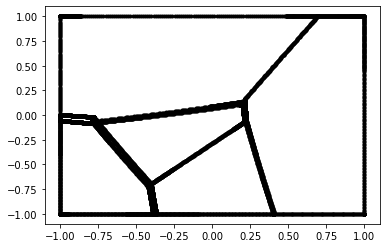

[[ -2.21   0.92   0.     1.04   0.24]
 [  0.97  -2.58   0.25   0.     1.36]
 [  0.     0.28  -4.58   0.94   3.36]
 [  1.03   0.     0.88  -8.56   6.66]
 [  0.23   1.39   3.18   6.61 -11.42]]
t=0.1
3 -> 
H(psi) =  [1.28 1.42 0.46 0.47 0.43]
psi =  [0.3  0.3  0.11 0.15 0.15]


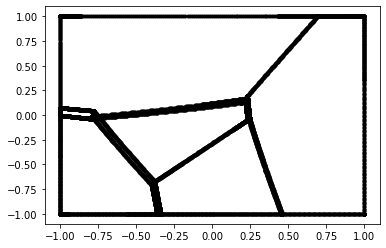

[[ -2.24   0.89   0.     1.09   0.26]
 [  0.96  -2.6    0.26   0.     1.38]
 [  0.     0.29  -4.99   1.03   3.66]
 [  1.07   0.     0.95  -8.78   6.75]
 [  0.25   1.44   3.42   6.7  -11.8 ]]
t=0.1
4 -> 
H(psi) =  [1.24 1.38 0.51 0.5  0.45]
psi =  [0.35 0.34 0.11 0.15 0.15]


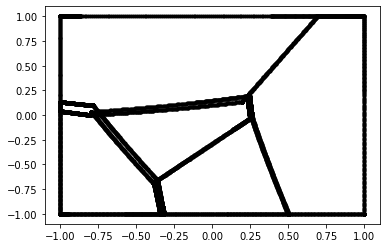

[[ -2.27   0.87   0.     1.12   0.28]
 [  0.95  -2.61   0.26   0.     1.41]
 [  0.     0.3   -5.35   1.09   3.95]
 [  1.11   0.     1.    -8.96   6.84]
 [  0.26   1.48   3.64   6.78 -12.16]]
t=0.1


In [37]:
psi = 0.11*np.ones(N)
def H_DH(psi):
    lag = make_laguerre(Y, psi, beta, k=100)
    plt.figure()
    plot_laguerre(lag)
    plt.show()
    return compute_H_DH_from_laguerre(Y,beta,lag)

h,dh = H_DH(psi)
for i in range(5):
    print("%d -> " % i) 
    print("H(psi) = ", H(psi))
    print("psi = ", psi)
    dh = dh[0:N-1,0:N-1]
    h = h[0:N-1]
    d = np.zeros(N)
    d[0:N-1] = -np.linalg.solve(dh, h - 4/N)
    t = 0.1
    d = d - min(d)
    psi0 = psi.copy()
    while True:
        psi = psi0 + t*d
        h,dh = H_DH(psi)
        if min(h) > 0:
            print(dh)
            print("t=%g"%t)
            break
        t = t/2
 

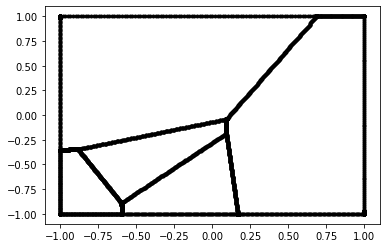

H(psi) =  [1.47 1.63 0.19 0.35 0.36]


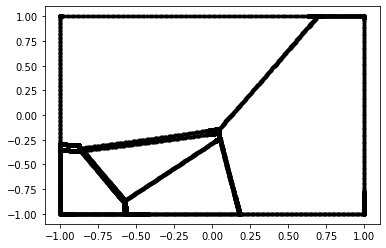

H(psi) =  [1.49 1.71 0.21 0.33 0.3 ]


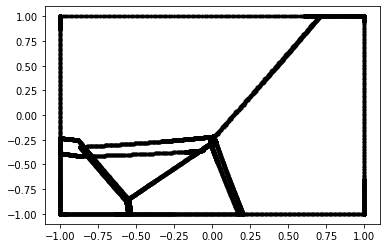

H(psi) =  [1.51 1.83 0.24 0.32 0.26]


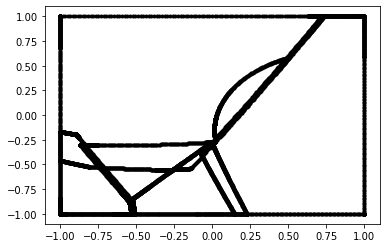

H(psi) =  [1.52 1.89 0.26 0.31 0.24]


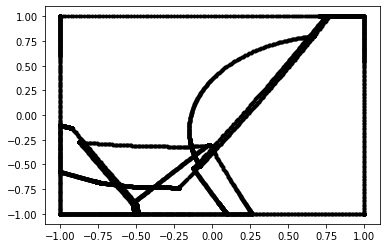

H(psi) =  [1.52 1.84 0.27 0.3  0.24]


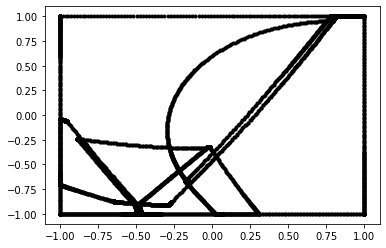

H(psi) =  [1.5  1.72 0.28 0.29 0.26]


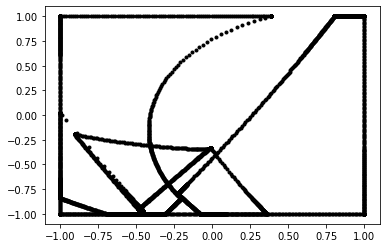

H(psi) =  [1.48 1.46 0.28 0.29 0.28]


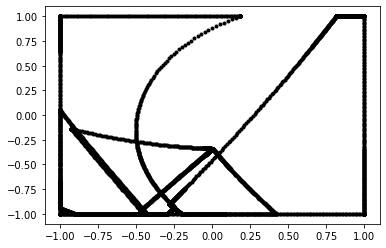

H(psi) =  [1.48 1.3  0.29 0.3  0.31]


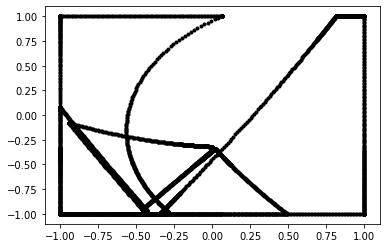

H(psi) =  [1.49 1.16 0.31 0.32 0.34]


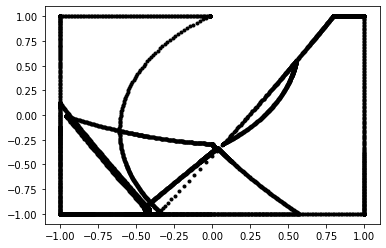

H(psi) =  [1.47 1.06 0.34 0.34 0.36]


In [41]:
# gradient descent

psi = 1*np.ones(N)
for i in range(10):
    h,dh = H_DH(psi)
    print("H(psi) = ", h)
    psi = psi + 0.1*(h-4/N)

In [ ]:
def area_of_cell(curves):
    if curves is None:
        return 0.0
    area = 0.0
    # compute area of cell i by integrating over the boundary
    # j is the number of the adjacent cell (negative number if adjacency 
    # is with the boundary)
    for j,curvesj in curves.items():
        for crv in curvesj:
            crv = np.array(crv)
            for k in range(crv.shape[0]-1):
                a = crv[k,0:2]
                b = crv[k+1,0:2]
                area += np.linalg.det(np.array([a,b]))/2
    return area

def areas_of_power_diagram_quadric_intersection(X,w,quad):
    cells = pypower.power_diagram(X,w)
    areas = [area_of_cell(intersect_cell_with_quadric(X,c,quad,20)) for c in cells]
    return np.array(areas)
 
N = 10
quad = Quadric(np.diag([-1,-1,0]), np.array([0,0,1]), 1)
X = np.random.rand(N,3)
w = np.zeros(N)
H = lambda w: areas_of_power_diagram_quadric_intersection(X,w,quad)
H(w)

In [ ]:

def enlarge(x):
    z = np.zeros(len(x)+1)
    z[1:] = x
    return z
x = opt.fsolve(lambda x: (H(enlarge(x)) - 4/N)[1:], np.zeros(N-1))
w = enlarge(x)

In [ ]:
# Oliker-Prussner
N = 10
X = np.random.rand(N,3)
w = np.zeros(N)
w[0] = 5
delta = 0.35
nu = 4*np.ones(N)/N

def H(w):
    return areas_of_power_diagram_quadric_intersection(X,w,quad)
def Hi(w,i):
    cells = pypower.power_diagram(X,w)
    return area_of_cell(intersect_cell_with_quadric(X,cells[i],quad,20))
def e(i):
    x = np.zeros(N)
    x[i] = 1
    return x
    
while delta>0.01:
    print("delta={}".format(delta))
    good = False
    while not good:
        good = True
        t = np.zeros(N)
        for i in range(1,N):
            if Hi(w,i) >= nu[i] - delta:
                continue
            f = lambda s: Hi(w+s*e(i),i) - nu[i]
            # cell i does not have enough mass: we need to increase w
            t[i] = opt.root_scalar(f, bracket=[0,10]).root
            good = False
        print(np.linalg.norm(H(w) - 4/N))
        w = w + t
    delta /= 2

In [ ]:
# check (visually) the computation of the intersection between a triangle and a quadric

def trisample(A, B, C,N):
    r1 = np.random.rand(N)
    r2 = np.random.rand(N)
    s1 = np.sqrt(r1)

    X = np.zeros((N,3))
    X[:,0] = A[0] * (1.0 - s1) + B[0] * (1.0 - r2) * s1 + C[0] * r2 * s1
    X[:,1] = A[1] * (1.0 - s1) + B[1] * (1.0 - r2) * s1 + C[1] * r2 * s1
    X[:,2] = A[2] * (1.0 - s1) + B[2] * (1.0 - r2) * s1 + C[2] * r2 * s1
    return X


def test_triangle():
    above = np.array([0,0,2])
    quad = make_quad(np.array([0,0]),0,1)
    v = np.random.rand(3)
    w = np.random.rand(3)
    
    X = trisample(above,v,w,1000)
    s = np.array([quad(x) for x in X]).flatten()
    plt.plot(X[s>0,0], X[s>0,1],'.r')
    plt.plot(X[s<0,0], X[s<0,1],'.b')

    curves = intersect_triangle_with_quadric(quad, v, w, above)
    for c in curves:
        plt.plot(c[:,0], c[:,1],'g', linewidth=4)
        
#test_triangle()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

quad = make_quad(np.array([0,0]),0,.1)

N= 5
X = np.random.rand(N,3)
w = np.zeros(N)
cells = make_power(X,w)

area = 0
plt.figure(figsize=(10,10))
for i in range(N):
    curves = intersect_cell_with_quadric(X,cells[i],quad,30)
    if curves is None:
        print("empty cell {}".format(i))
        continue
    for j,curvesj in curves.items():
        for crv in curvesj:
            crv = np.array(crv)
            for i in range(crv.shape[0]-1):
                a = crv[i,0:2]
                b = crv[i+1,0:2]
                area += np.linalg.det(np.array([a,b]))/2
            plt.plot(crv[:,0], crv[:,1], 'k')
print(area)